Modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.ticker import MaxNLocator
from scipy.optimize import brentq
from scipy.optimize import minimize

Data cleaning and preparation:

In [2]:
##### Import data ##### 
### Monthly SP500TR ###
# Read CSV file for SP500TR
SP500TR = pd.read_csv('SP500TR.csv')

# Remove the first two rows and keep only the first two columns 
SP500TR = SP500TR.iloc[2:, :2]

# Rename columns
SP500TR.columns = ["Date", "SP500TR"]

# Set Date as index
SP500TR.set_index("Date", inplace=True)

# Convert index to datetime 
SP500TR.index = pd.to_datetime(SP500TR.index)

# Fix issue with SP500TR not being numeric
SP500TR["SP500TR"] = pd.to_numeric(SP500TR["SP500TR"], errors='coerce')

### Monthly SPBDUB3T ###
SPBDUB3T = pd.read_excel('SPBDUB3T.xlsx', index_col=0)

# Convert index to datetime 
SPBDUB3T.index = pd.to_datetime(SPBDUB3T.index)

# Change index to first of month
SPBDUB3T.index = SPBDUB3T.index.to_period('M').to_timestamp()

### Monthly PCE ###
PCE =  pd.read_csv('PCE.csv', index_col=0)

# Convert index to datetime 
PCE.index = pd.to_datetime(PCE.index)

### Monthly PCEPI ###
PCEPI =  pd.read_csv('PCEPI.csv', index_col=0)

# Convert index to datetime 
PCEPI.index = pd.to_datetime(PCEPI.index)

##### Join DataFrames #####
# Join on the dates of SPBDUB3T
df = SPBDUB3T.join([SP500TR, PCE, PCEPI], how='left')

# Define start and end dates 
start_date, end_date = '1989-12-01', '2024-12-01'

# Slice the DataFrame between the two dates
df = df.loc[start_date:end_date]

### Monthly Data ###
df_monthly = df.copy()

# Calculate monthly return and changes for SP500TR, SPBDUB3T, PCE, PCEPI and EP
df_monthly["RET_SPBDUB3T"] = (df_monthly["SPBDUB3T"] / df_monthly["SPBDUB3T"].shift(1) - 1)
df_monthly["RET_SP500TR"] = (df_monthly["SP500TR"] / df_monthly["SP500TR"].shift(1) - 1)
df_monthly["CHG_PCE"] = (df_monthly["PCE"] / df_monthly["PCE"].shift(1) - 1)
df_monthly["CHG_PCEPI"] = (df_monthly["PCEPI"] / df_monthly["PCEPI"].shift(1) - 1)
df_monthly["RET_EP"] = df_monthly["RET_SP500TR"] - df_monthly["RET_SPBDUB3T"]


# Calculate monthly real return and changes for SP500TR, SPBDUB3T, PCE, PCEPI and EP
df_monthly["R_RET_SPBDUB3T"] = ((1+df_monthly["RET_SPBDUB3T"])/(1+df_monthly["CHG_PCEPI"]) - 1)
df_monthly["R_RET_SP500TR"] = ((1+df_monthly["RET_SP500TR"])/(1+df_monthly["CHG_PCEPI"]) - 1)
df_monthly["R_CHG_PCE"] = ((1+df_monthly["CHG_PCE"])/(1+df_monthly["CHG_PCEPI"]) - 1)
df_monthly["R_RET_EP"] = df_monthly["R_RET_SP500TR"] - df_monthly["R_RET_SPBDUB3T"]

### Yearly Data ###
df_yearly = df.copy()

# Filter for December
df_yearly = df_yearly[df_yearly.index.month == 12]

# Calculate yearly return and changes for SP500TR, SPBDUB3T, PCE, PCEPI and EP
df_yearly["RET_SPBDUB3T"] = (df_yearly["SPBDUB3T"] / df_yearly["SPBDUB3T"].shift(1) - 1)
df_yearly["RET_SP500TR"] = (df_yearly["SP500TR"] / df_yearly["SP500TR"].shift(1) - 1)
df_yearly["CHG_PCE"] = (df_yearly["PCE"] / df_yearly["PCE"].shift(1) - 1)
df_yearly["CHG_PCEPI"] = (df_yearly["PCEPI"] / df_yearly["PCEPI"].shift(1) - 1)
df_yearly["RET_EP"] = df_yearly["RET_SP500TR"] - df_yearly["RET_SPBDUB3T"]

# Calculate yearly real return and changes for SP500TR, SPBDUB3T, PCE, PCEPI and EP
df_yearly["R_RET_SPBDUB3T"] = ((1+df_yearly["RET_SPBDUB3T"])/(1+df_yearly["CHG_PCEPI"]) - 1)
df_yearly["R_RET_SP500TR"] = ((1+df_yearly["RET_SP500TR"])/(1+df_yearly["CHG_PCEPI"]) - 1)
df_yearly["R_CHG_PCE"] = ((1+df_yearly["CHG_PCE"])/(1+df_yearly["CHG_PCEPI"]) - 1)
df_yearly["R_RET_EP"] = df_yearly["R_RET_SP500TR"] - df_yearly["R_RET_SPBDUB3T"]

Data exploration and visualization:

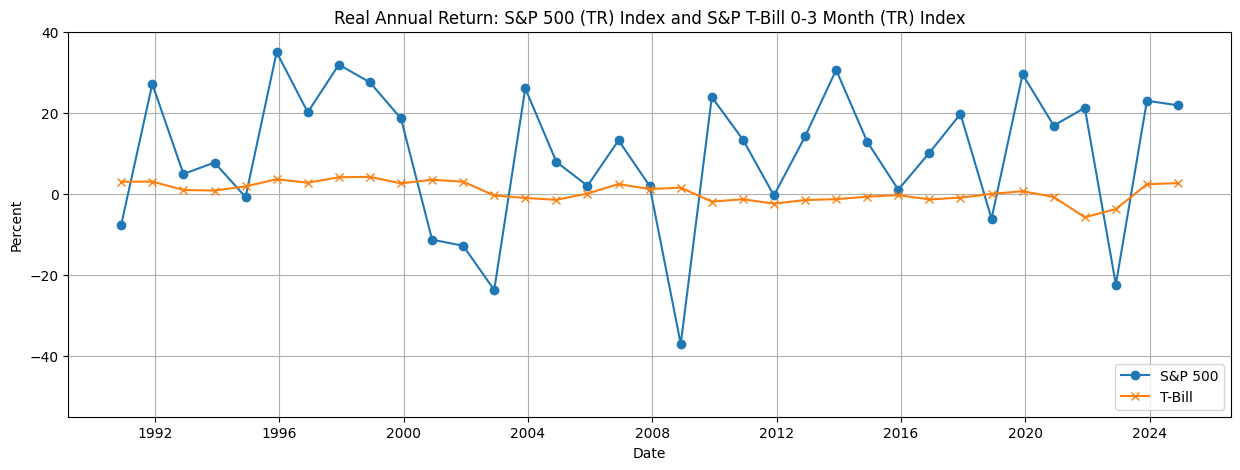

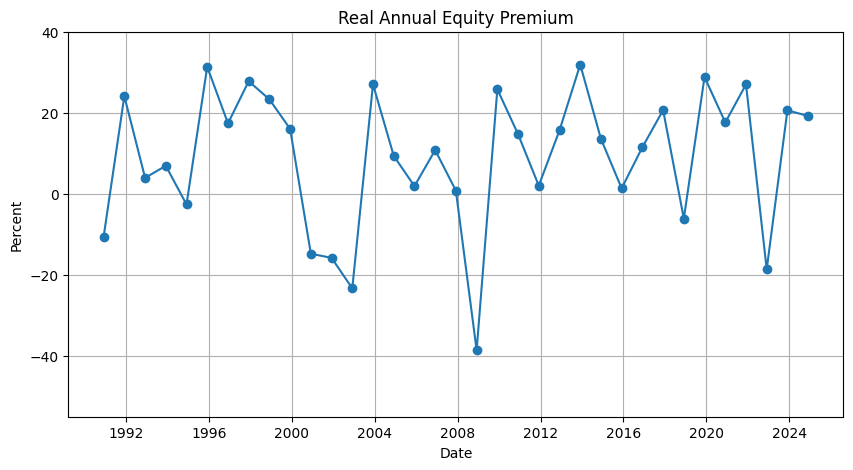

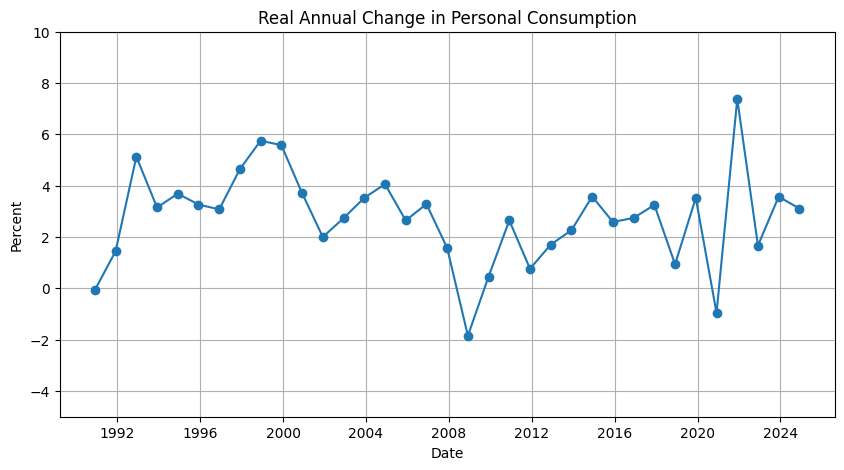

In [4]:
# Real Market Return and Yield
plt.figure(figsize=(15, 5))
plt.plot(df_yearly.index, df_yearly['R_RET_SP500TR']*100, marker='o', label="S&P 500")
plt.plot(df_yearly.index, df_yearly["R_RET_SPBDUB3T"]*100, marker='x', label="T-Bill")
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Return: S&P 500 (TR) Index and S&P T-Bill 0-3 Month (TR) Index')
plt.legend(loc="lower right")
plt.ylim(-55, 40)
plt.grid()
plt.show()

# Real Equity Premium
plt.figure(figsize=(10, 5))
plt.plot(df_yearly.index, df_yearly["R_RET_EP"]*100, marker='o')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Equity Premium')
plt.ylim(-55, 40)
plt.grid()
plt.show()

# Real Growth Rate of Consumption
plt.figure(figsize=(10, 5))
plt.plot(df_yearly.index, df_yearly['R_CHG_PCE']*100, marker='o')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Change in Personal Consumption')
plt.ylim(-5, 10)
plt.grid()
plt.show()

Mehra and Prescott (2003):

In [31]:
### Set the variables of the model ###

# Mean and variance of real consumption growth (from simple returns)
E_x = (1 + df_yearly["R_CHG_PCE"]).mean()           # Convert to gross return
var_x = df_yearly["R_CHG_PCE"].var()                # Variance of simple returns

# Convert to log mean and log variance
sigma_x2 = np.log(1 + var_x / E_x**2)               # log-variance of consumption growth
mu_x = np.log(E_x) - 0.5 * sigma_x2                 # log-mean of consumption growth

### Set beta and alpha ###
alpha = 10
beta = 0.99

### Expected real return on equity and risk-free asset ###
E_Rf = -np.log(beta) + alpha * mu_x - 0.5 * (alpha**2) * sigma_x2
E_Re = E_Rf + alpha * sigma_x2
E_Rp = E_Re - E_Rf

# Print results
print(f"Real expected return on equity is {np.round(E_Re * 100, 5)}%")
print(f"Real expected return on risk-free asset is {np.round(E_Rf * 100, 5)}%")
print(f"Equity risk-premium is given by {np.round(E_Rp * 100, 5)}%")

Real expected return on equity is 26.78372%
Real expected return on risk-free asset is 26.45943%
Equity risk-premium is given by 0.32429%


In [32]:
### Prescott and Mehra (2003) ###

# Mean real consumption growth rate (gross)
E_x_mp = 1.018

# Standard deviation of real consumption growth rate (in levels)
sigma_x_level = 0.036
var_x = sigma_x_level**2

# Compute log-variance of consumption growth rate
sigma2_x_mp = np.log(1 + var_x / E_x_mp**2)

# Compute log-mean of consumption growth
mu_x_mp = np.log(E_x_mp) - 0.5 * sigma2_x_mp

### Set beta and alpha ###
alpha_mp = 10
beta_mp = 0.99

### Expected real return on equity and risk-free asset ###

# Real risk-free return (continuously compounded)
E_Rf_mp = -np.log(beta_mp) + alpha_mp * mu_x_mp - 0.5 * (alpha_mp**2) * sigma2_x_mp

# Real equity return
E_Re_mp = E_Rf_mp + alpha_mp * sigma2_x_mp

# Equity risk premium
E_Rp_mp = E_Re_mp - E_Rf_mp

# Print results
print(f"Real expected return on equity: {np.round(E_Re_mp * 100, 5)}%")
print(f"Real expected return on risk-free asset: {np.round(E_Rf_mp * 100, 5)}%")
print(f"Equity risk premium: {np.round(E_Rp_mp * 100, 5)}%")


Real expected return on equity: 13.22088%
Real expected return on risk-free asset: 11.97109%
Equity risk premium: 1.24979%


In [33]:
### Magnitude of equity premium puzzle ###
magnitude = E_Rp_mp/E_Rp

print(f"As the model is linear in its parameters one can easily conclude that the equity premium puzzle has increased by a magnitude of {np.round(magnitude,5)}.")

As the model is linear in its parameters one can easily conclude that the equity premium puzzle has increased by a magnitude of 3.8539.


Benartzi and Thaler (1995):

In [34]:
# Define block bootstrap function
# def block_bootstrap(x, block_length=12, n_samples=100000):
#    n = len(x)
#    returns = []
#
#    for _ in range(n_samples):
#        last_start = n - block_length
#        start = np.random.randint(0, last_start + 1)  # +1 because upper bound is exclusive
#        block = x[start:start + block_length]
#        block_return = np.prod(1 + block) - 1
#        returns.append(block_return)
#
#   return np.array(returns)
#
# Initialize storage dictionaries

# bond_data = {}
# stock_data = {}

# Generate bootstrapped samples for block lengths 1 to 18
# for i in range(1, 19):
#    bond_data[i] = block_bootstrap(df_monthly["RET_SPBDUB3T"], block_length=i, n_samples=100000)
#    stock_data[i] = block_bootstrap(df_monthly["RET_SP500TR"], block_length=i, n_samples=100000)

# Convert to DataFrames
# bond_df = pd.DataFrame(bond_data)
# stock_df = pd.DataFrame(stock_data)

# Save to CSV
# bond_df.to_csv("bond_data.csv", index=False)
# stock_df.to_csv("stock_data.csv", index=False)

In [35]:
alpha, lam, gamma_gain, gamma_loss =  [0.48271105, 1.21028964, 0.5827681,  0.62565051]
beta = alpha

# Define value function
def value_function(x, alpha, beta, lam):
    if x >= 0:
        return x**alpha
    else:
        return -lam * ((-x)**beta)
    
# Define weighting function
def weighting_function(p, gamma):
    if p == 0: 
        return 0
    elif p == 1:
        return 1
    else: 
        return (p**gamma)/((p**gamma + (1 - p)**gamma)**(1/gamma))

def cpt_utility(x, alpha, beta, lam, gamma_gain, gamma_loss):
    # Sort values ascending
    x = np.sort(x)

    # Find length of data
    n = len(x)

    # Seperate into gains and losses
    x_gain = x[(x >= 0)]
    x_loss = x[(x < 0)]

    ### Gains ###
    if len(x_gain) > 0:
        # CDF for gains
        ECDF_gain = ECDF(x_gain)

        # Unique values for the gains
        unique_gain = np.unique(x_gain)

        # CCDF = 1 - ECDF(x) + P(X = x)
        unique_probs_gain = (1 - ECDF_gain(unique_gain) + np.array([np.sum(x_gain == x) / len(x_gain) for x in unique_gain])) * (len(x_gain)/n)

        ### Prospect utility for gains ###
        # Add zero to the end of probabilities
        unique_probs_gain_with_zero = np.append(unique_probs_gain, 0)

        # Initialize utility
        utility_gain = 0

        for i in range(len(unique_gain)):
            utility_gain += value_function(unique_gain[i], alpha, beta, lam) \
                * (weighting_function(unique_probs_gain_with_zero[i], gamma=gamma_gain) \
                    - weighting_function(unique_probs_gain_with_zero[i+1], gamma=gamma_gain))

    else:
        utility_gain = 0

    if len(x_loss) > 0: 
    ### Losses ###
    # CDF for losses
        ECDF_loss = ECDF(x_loss)

        # Unique valus for the losses
        unique_loss = np.unique(x_loss)

        # Get ECDF probabilities at the unique values
        unique_probs_loss = ECDF_loss(unique_loss) * (len(x_loss)/n)

        ### Prospect utility for losses ###
        # Sort descending and add zero at the end of probabilities
        unique_loss_desc = unique_loss[::-1]
        unique_probs_loss_desc_with_zero = np.append(unique_probs_loss[::-1], 0)

        # Initialize utility
        utility_loss = 0

        for i in range(len(unique_loss_desc)):
            utility_loss += value_function(unique_loss_desc[i], alpha, beta, lam) \
                * (weighting_function(unique_probs_loss_desc_with_zero[i], gamma=gamma_loss) \
                    - weighting_function(unique_probs_loss_desc_with_zero[i+1], gamma=gamma_loss))

    else:
        utility_loss = 0
        
    ### Sum of utilities ###
    utility = utility_loss + utility_gain

    return utility

In [36]:
# Load the bootstrapped return data
bond_df = pd.read_csv("bond_data.csv")
stock_df = pd.read_csv("stock_data.csv")

# Compute prospective utility using cpt_utility for each column (block length)
bond_utility = [cpt_utility(bond_df[col].dropna().values, alpha, beta, lam, gamma_gain, gamma_loss) for col in bond_df.columns]
stock_utility = [cpt_utility(stock_df[col].dropna().values, alpha, beta, lam, gamma_gain, gamma_loss) for col in stock_df.columns]

# Convert results to DataFrames with proper labeling
bond_util_df = pd.DataFrame({
    "Horizon": bond_df.columns.astype(int),
    "Utility": bond_utility
})

stock_util_df = pd.DataFrame({
    "Horizon": stock_df.columns.astype(int),
    "Utility": stock_utility
})

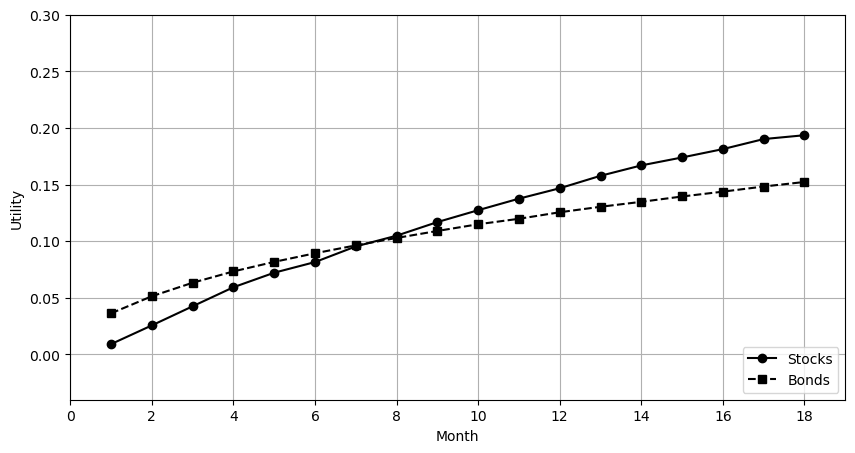

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(stock_util_df["Horizon"], stock_util_df["Utility"], marker='o', color="black", label="Stocks")
plt.plot(bond_util_df["Horizon"], bond_util_df["Utility"], marker='s', linestyle = "--", color="black", label="Bonds")
plt.xlabel('Month')
plt.ylabel('Utility')
plt.legend(loc="lower right")
plt.ylim(-0.04, 0.30)
plt.xlim(0, 19)
plt.grid()

# Force whole number ticks on x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

In [14]:
lengths = [8]

n = 21
weights = np.linspace(0, 1, n)

records = []

for length in lengths:
    ret_stock = stock_df[str(length)].values
    ret_bond  = bond_df[str(length)].values

    ret_port = np.zeros((len(ret_stock), n))
    for j, w in enumerate(weights):
        ret_port[:, j] = w * ret_stock + (1 - w) * ret_bond

    for j, w in enumerate(weights):
        u = cpt_utility(ret_port[:, j], alpha, beta, lam, gamma_gain, gamma_loss)
        records.append({
            'length': length,
            'weight_stock': round(w, 2),
            'utility': u
        })

results_df = pd.DataFrame.from_records(records)

pivot_df = results_df.pivot(
    index='length',
    columns='weight_stock',
    values='utility'
)

results_df.to_csv('cpt_utilities_long_new_params.csv', index=False)
pivot_df.to_csv('cpt_utilities_wide_new_params.csv')

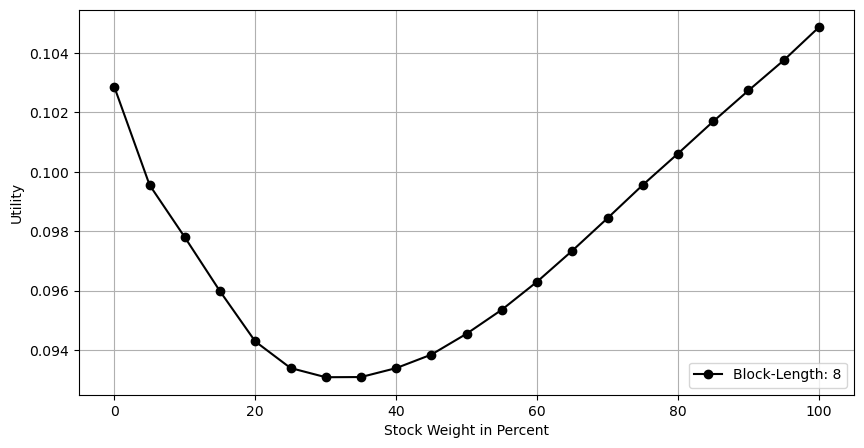

In [ ]:
# Load your data
long_df = pd.read_csv('cpt_utilities_long_new_params.csv')

# Define block lengths and markers
lengths = [8]  # example lengths, adjust as needed
markers = ['o']

# Reverse both lists to plot the largest length first
lengths = lengths[::-1]
markers = markers[::-1]

plt.figure(figsize=(10, 5))

for length, marker in zip(lengths, markers):
    subset = long_df[long_df['length'] == length]
    plt.plot(
        subset['weight_stock'].values * 100,
        subset['utility'].values,
        marker=marker,
        label=f'Block-Length: {length}',
        color='black',
        linestyle='-',
    )

plt.xlabel('Stock Weight in Percent')
plt.ylabel('Utility')
plt.grid()
plt.show()


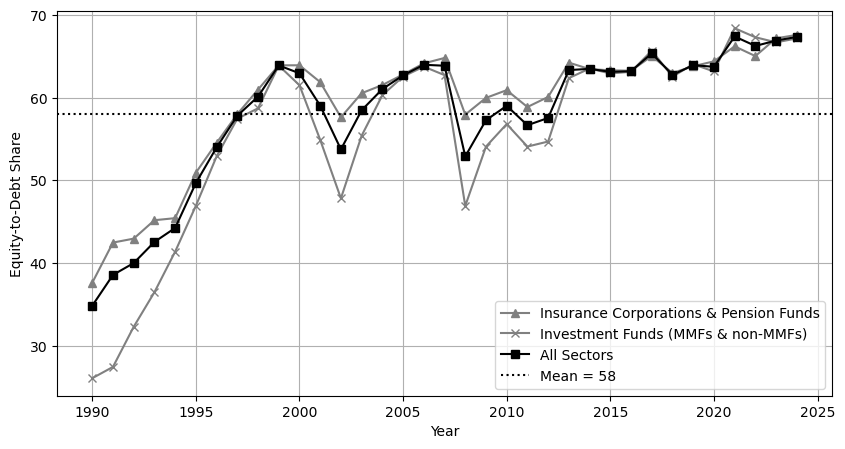

In [16]:
# Load the data
df = pd.read_excel('funds.xlsx')

# Identify the year column (assumed first column)
year_col = df.columns[0]

# Select only the requested equity-share series
cols = ['share_inv_fund_equity', 'share_ic_pf_fund_equity', 'total_equity_share']
df_sel = df[[year_col] + cols]

# Compute the mean of total_equity_share
mean_total_equity = df_sel['total_equity_share'].mean()

# Plot equity share over time with updated long-form labels
plt.figure(figsize=(10, 5))

# Insurance Corporations series: grey triangle
plt.plot(
    df_sel[year_col], df_sel['share_ic_pf_fund_equity']*100,
    color='grey', marker='^', linestyle='-',
    label='Insurance Corporations & Pension Funds'
)

# Investment Funds series: black square
plt.plot(
    df_sel[year_col], df_sel['share_inv_fund_equity']*100,
    color='grey', marker='x', linestyle='-',
    label='Investment Funds (MMFs & non‑MMFs)'
)

# Total Equity Share: black x-mark with dashed line
plt.plot(
    df_sel[year_col], df_sel['total_equity_share']*100,
    color='black', marker='s', linestyle='-',
    label='All Sectors'
)

# Mean line: grey dotted, with updated label
plt.axhline(
    mean_total_equity*100,
    color='black', linestyle=':',
    label=f'Mean = {mean_total_equity*100:.0f}'
)

plt.xlabel(year_col)
plt.ylabel('Equity-to-Debt Share')
plt.legend()
plt.grid()
plt.show()


In [23]:
# Load your horizon‐cumulative bootstraps
bond_df  = pd.read_csv("bond_data.csv")   # cols = '1','2',…,'18'
stock_df = pd.read_csv("stock_data.csv")

results = []

for col in bond_df.columns:
    # 1) horizon in months
    h = int(col)
    
    # 2) get the h-month cumulative-return draws
    bond_h  = bond_df[col].dropna().values
    stock_h = stock_df[col].dropna().values

    # 3) target utility of stocks
    U_s = cpt_utility(stock_h, alpha, beta, lam, gamma_gain, gamma_loss)

    # 4) solve for the horizon premium r_h (added to each draw)
    def objective(r):
        return cpt_utility(bond_h + r, alpha, beta, lam, gamma_gain, gamma_loss) - U_s

    # bracket r_h reasonably wide
    r_h = brentq(objective, a=-1, b=1, xtol=1e-8)

    # 5) annualize that horizon premium:
    #    (1 + r_h)^(12/h) – 1
    r_annual = (1 + r_h)**(12/h) - 1

    # 6) compute implied annual premium as the difference
    #    between annualized stock vs. bond+premium means
    ann_stock = (1 + stock_h)**(12/h) - 1
    ann_bond  = (1 + (bond_h + r_h))**(12/h) - 1
    implied_annual = ann_stock.mean() - ann_bond.mean()

    results.append({
        "horizon_months":      h,
        "r_horizon_cum":       r_h,
        "r_annualized":        r_annual,
        "implied_annual_prem": implied_annual
    })

premia_df = pd.DataFrame(results).sort_values("horizon_months")

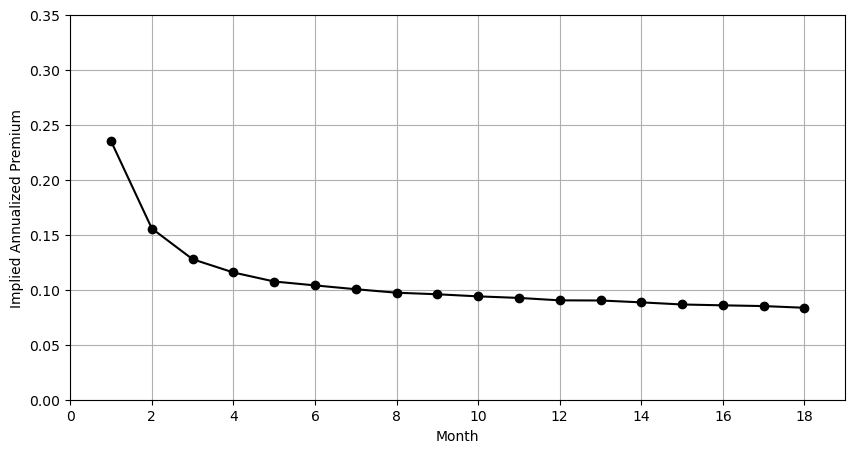

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(premia_df["horizon_months"], premia_df["implied_annual_prem"], marker='o', color='black')
plt.xlabel('Month')
plt.ylabel('Implied Annualized Premium')
plt.ylim(0, 0.35)
plt.xlim(0, 19)
plt.grid()

# Force whole number ticks on x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

In [37]:
real_premia = []

for h in range(1, 19):
    stock_h = df_monthly["SP500TR"] / df_monthly["SP500TR"].shift(h) - 1
    bond_h = df_monthly["SPBDUB3T"] / df_monthly["SPBDUB3T"].shift(h) - 1

    # Drop missing values
    valid = stock_h.notna() & bond_h.notna()
    stock_h, bond_h = stock_h[valid], bond_h[valid]

    # Annualize
    ann_stock = (1 + stock_h).pow(12 / h) - 1
    ann_bond = (1 + bond_h).pow(12 / h) - 1

    # Realized premium
    real_premium = ann_stock.mean() - ann_bond.mean()

    real_premia.append({
        "horizon_months": h,
        "realized_annual_premium": real_premium
    })

real_premia_df = pd.DataFrame(real_premia)

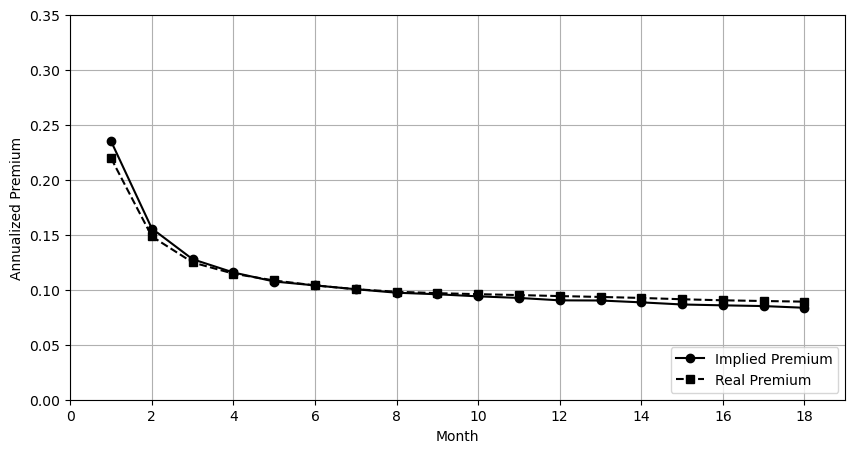

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(premia_df["horizon_months"], premia_df["implied_annual_prem"], marker='o', color='black', label="Implied Premium")
plt.plot(real_premia_df["horizon_months"], real_premia_df["realized_annual_premium"], linestyle = "--", marker='s', color='black', label="Real Premium")
plt.xlabel('Month')
plt.ylabel('Annualized Premium')
plt.ylim(0, 0.35)
plt.xlim(0, 19)
plt.legend(loc="lower right")
plt.grid()

# Force whole number ticks on x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


In [38]:
# Bounds for parameters
bounds = [
    (0.50, 0.99),   # alpha = beta
    (1.25, 2.75),    # lam
    (0.50, 0.99),   # gamma_gain
    (0.50, 0.99),   # gamma_loss
]

# Nonlinear constraint: gamma_loss - gamma_gain > 0.001
def constraint_gamma(params):
    gamma_gain = params[2]
    gamma_loss = params[3]
    return gamma_loss - gamma_gain - 0.001

nonlinear_constraint = {
    'type': 'ineq',
    'fun': constraint_gamma
}

# Objective function
def sse_objective_constrained(params):
    alpha, lam, gamma_gain, gamma_loss = params
    beta = alpha  # enforce alpha = beta

    results = []

    for col in bond_df.columns:
        h = int(col)
        bond_h = bond_df[col].dropna().values
        stock_h = stock_df[col].dropna().values

        U_s = cpt_utility(stock_h, alpha, beta, lam, gamma_gain, gamma_loss)

        def objective(r):
            return cpt_utility(bond_h + r, alpha, beta, lam, gamma_gain, gamma_loss) - U_s

        try:
            r_h = brentq(objective, a=-0.10, b=0.10, xtol=1e-4)
        except ValueError:
            return np.inf

        r_annual = (1 + r_h)**(12/h) - 1
        ann_stock = (1 + stock_h)**(12/h) - 1
        ann_bond = (1 + (bond_h + r_h))**(12/h) - 1
        implied_annual = ann_stock.mean() - ann_bond.mean()

        results.append(implied_annual)

    model = np.array(results)
    actual = real_premia_df["realized_annual_premium"].values
    sse = np.sum((model - actual) ** 2)
    return sse

# Multi-start loop
best_result = None
num_starts = 30

for i in range(num_starts):
    # Sample a valid initial guess
    while True:
        initial_guess = [
            np.random.uniform(*bounds[0]),  # alpha
            np.random.uniform(*bounds[1]),  # lambda
            np.random.uniform(*bounds[2]),  # gamma_gain
            np.random.uniform(*bounds[3])   # gamma_loss
        ]
        if initial_guess[2] < initial_guess[3]:  # gamma_gain < gamma_loss
            break

    result = minimize(
        sse_objective_constrained,
        initial_guess,
        bounds=bounds,
        method='SLSQP',
        constraints=[nonlinear_constraint],
        options={
            'disp': False,
            'maxiter': 500,
            'ftol': 1e-4
        }
    )

    if best_result is None or result.fun < best_result.fun:
        best_result = result
        print(f"New best result at start {i+1}: SSE = {result.fun:.6f}")

# Final result
print("\nBest overall result from multi-start optimization:")
print("Optimal parameters (alpha=beta enforced):", best_result.x)
print("Minimum SSE:", best_result.fun)


New best result at start 1: SSE = 0.000853
New best result at start 18: SSE = 0.000775


c:\Users\jonas\anaconda3\envs\newenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


New best result at start 30: SSE = 0.000579

Best overall result from multi-start optimization:
Optimal parameters (alpha=beta enforced): [0.5        1.2724478  0.55664537 0.69452227]
Minimum SSE: 0.0005792368278208224


In [ ]:
best = [0.48271105, 1.21028964, 0.5827681,  0.62565051]
best_fun = 0.00044985432567405117

In [39]:
best_30 = [0.5 ,       1.2724478 , 0.55664537 ,0.69452227]
best_fun_30 = 0.0005792368278208224